In [1]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
os.chdir("../../../")
os.getcwd()

'/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering'

In [5]:
torch.hub.set_dir('/scratch/jlaw/torch')
model_name = "esm2_t33_650M_UR50D"
# model_name = "esm2_t36_3B_UR50D"
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)

Using cache found in /scratch/jlaw/torch/facebookresearch_esm_main


### Build/get embeddings

In [6]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

In [7]:
# inputs_dir = Path("/projects/robustmicrob/jlaw/inputs/")
inputs_dir = "inputs/brenda"

embeddings, df_seq = read_embeddings(Path(inputs_dir, "ph_range/uniprot/20230913_embeddings_esm2_t33_650M_UR50D.npz"),
                                     Path(inputs_dir, "ph_range/uniprot/20230913_embeddings_seqs.csv"))

# embeddings2, df_seq2 = read_embeddings(Path(inputs_dir, "uniprot/embeddings/20230504_embeddings_esm2_t33_650M_UR50D.npz"),
#                                           Path(inputs_dir, "uniprot/embeddings/20230504_embeddings_seqs.csv"))

# embeddings = np.vstack([embeddings, embeddings2])
print(embeddings.shape)
# df_seq = pd.concat([df_seq, df_seq2], ignore_index=True).reset_index(drop=True)

len(embeddings) = 4917 read from inputs/brenda/ph_range/uniprot/20230913_embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 4917 read from inputs/brenda/ph_range/uniprot/20230913_embeddings_seqs.csv
(4917, 1280)


In [8]:
# This file has the ph range data + optimum ph data
# data_file = Path(inputs_dir, "ph_range/20230726_ph_activity_data_merged.csv")
# This file has the ph range data 
data_file = Path(inputs_dir, "ph_range/20230907_ph_range_processed_act_wopt.csv")
data_act_merged = pd.read_csv(data_file)
print(len(data_act_merged), data_act_merged.exp_index.nunique(), data_act_merged.uniprot_id.nunique())
data_act_merged.head(2)

9440 3178 2566


,exp_index,ph,activity,note,ph_range_comment,uniprot_id
0,1,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46
1,1,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46


In [9]:
data_file = Path(inputs_dir, "ph_range/20230907_ph_range_wrxn_type.csv")
data_ph = pd.read_csv(data_file, index_col=0)
print(len(data_ph))
data_ph.head(2)

3158


,ec_num,ph_min,ph_max,comments,organism,uniprot_id,ref,substrates,products,notes,reaction_type,substrates_rev,condition,to_fix,notes.1,name,enzyme_type,enzyme_type_sub,acceptor
5423,3.2.1.73,6.0,11,"pH 6.0: about 55% of maximal activity, pH 11.0...",Brevibacillus brevis,P37073,171543,lichenan + H2O,?,NaN,NaN,NaN,NaN,NaN,NaN,licheninase,Hydrolases,Glycosylases,NaN
2478,3.2.1.7,3.0,7,over 70% of maximal activity within this range...,Aspergillus niger,O74641,750226,inulin + H2O,?,NaN,NaN,NaN,NaN,NaN,NaN,inulinase,Hydrolases,Glycosylases,NaN


In [10]:
data_act_merged = data_act_merged[data_act_merged.exp_index.isin(data_ph.index)]
print(len(data_act_merged))

9383


In [11]:
# now limit the proteins to those with an embedding
data_act_merged2 = data_act_merged[data_act_merged.uniprot_id.isin(df_seq.uniprot_id)]
print(data_act_merged2.uniprot_id.nunique(), len(data_act_merged2))

2496 9154


In [12]:
uniprot_to_seq = dict(zip(df_seq.uniprot_id, df_seq.sequence))

In [13]:
data_ph.uniprot_id.nunique()

2566

In [14]:
data_ph.head(2)

,ec_num,ph_min,ph_max,comments,organism,uniprot_id,ref,substrates,products,notes,reaction_type,substrates_rev,condition,to_fix,notes.1,name,enzyme_type,enzyme_type_sub,acceptor
5423,3.2.1.73,6.0,11,"pH 6.0: about 55% of maximal activity, pH 11.0...",Brevibacillus brevis,P37073,171543,lichenan + H2O,?,NaN,NaN,NaN,NaN,NaN,NaN,licheninase,Hydrolases,Glycosylases,NaN
2478,3.2.1.7,3.0,7,over 70% of maximal activity within this range...,Aspergillus niger,O74641,750226,inulin + H2O,?,NaN,NaN,NaN,NaN,NaN,NaN,inulinase,Hydrolases,Glycosylases,NaN


In [15]:
# try using a one-hot encoding of just oxidation and reduction
data_ph['oxidation'] = data_ph.enzyme_type.apply(lambda x: x == 'oxidation').astype(int)
data_ph['reduction'] = data_ph.enzyme_type.apply(lambda x: x == 'reduction').astype(int)
data_ph[data_ph.enzyme_type == 'reduction'].head(2)

,ec_num,ph_min,ph_max,comments,organism,uniprot_id,ref,substrates,products,notes,...,substrates_rev,condition,to_fix,notes.1,name,enzyme_type,enzyme_type_sub,acceptor,oxidation,reduction
13,1.1.1.1,7.0,9.6,"pH 7.0: about 70% of maximal activity, pH 9.6:...",Aeropyrum pernix,Q9Y9P9,728012,"{'1-propanol + NAD+', '2-propanol + NAD+', 'et...","{'acetaldehyde + NADH + H+', '4-methoxybenzald...",{'reduction of 2-pentanone'},...,2-pentanone,NaN,NaN,NaN,alcohol dehydrogenase,reduction,CH-OH group of donors,NAD+ or NADP+,0,1
1,1.1.1.1,4.0,7.5,"pH 4.0: about 80% of maximal activity, pH 7.5:...",Candida parapsilosis,B2KJ46,684556,"{'2-hydroxyacetophenone + NADH + H+', '2-butan...","{'?', '1-ethoxy-2,2,2-trifluoroethanol + NADP+...",NaN,...,NaN,NaN,NaN,NaN,alcohol dehydrogenase,reduction,CH-OH group of donors,NAD+ or NADP+,0,1


In [16]:
# rather than get a unique sequence for each row, also take into account the reaction type
# data_feats = data_ph[['uniprot_id', 'enzyme_type', 'enzyme_type_sub', 'acceptor']]
data_feats = data_ph[['uniprot_id', 'oxidation', 'reduction']]
data_feats['sequence'] = data_feats.uniprot_id.apply(lambda x: uniprot_to_seq.get(x, np.nan))
data_feats = data_feats.dropna(subset='sequence')
print(len(data_feats), len(data_feats.drop_duplicates()))

3078 2526


/tmp/ipykernel_4291/1084569711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_feats['sequence'] = data_feats.uniprot_id.apply(lambda x: uniprot_to_seq.get(x, np.nan))


In [17]:
data_feats[['oxidation', 'reduction']].value_counts()

oxidation  reduction
0          0            2421
1          0             460
0          1             197
dtype: int64

In [ ]:
# TODO add weights to the loss function
# weights = 
# data_act_merged['weight'] = data_act_merged

In [20]:
df_seq_uniq = data_feats.reset_index()[['uniprot_id', 'sequence']].drop_duplicates()
print(len(df_seq_uniq), len(df_seq))
df_seq_uniq = df_seq_uniq[df_seq_uniq.uniprot_id.isin(data_act_merged.uniprot_id.unique())]
print(len(df_seq_uniq))

2495 4917
2495


In [53]:
df_seq_uniq.head(2)

,uniprot_id,sequence
0,B2KJ46,MGEIESYCNKELGPLPTKAPTLSKNVLDLFSLKGKVASVTGSSGGI...
1,Q6L0S1,MRAIVLERFGIENIKIEDIDDESPGIPVKITMAGLNPVDYSTVNGN...


In [21]:
# just take a random split for now
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_seq_uniq.set_index('uniprot_id'), test_size=0.1)
print(len(train), len(test))

2245 250


In [39]:
# optionally run this instead to keep the same train and test set as previous run
# # keep the same ph range test set
# train = df_seq_uniq[~df_seq_uniq.uniprot_id.isin(df_test.uniprot_id)].set_index('uniprot_id')
# test = df_seq_uniq[df_seq_uniq.uniprot_id.isin(df_test.uniprot_id)].set_index('uniprot_id')
# print(len(train), len(test))

7588 226


In [22]:
# df_seq.loc[df_seq.uniprot_id.isin(list(train.index)), 'set'] = 'train'
# df_seq.loc[df_seq.uniprot_id.isin(test.index), 'set'] = 'test'
# # df_seq.drop(columns=['Unnamed: 0'], inplace=True)
# df_split = df_seq
# df_seq.head(2)
train['set'] = 'train'
test['set'] = 'test'
df_split = pd.concat([train, test])
df_split.head(2)

,sequence,set
uniprot_id,,
Q5NTH0,MDSKIDSKTFRVVMLPWLAYSHISRFLVFAKRLTNHNFHIYICSSQ...,train
A0A1C9V3S9,MAGTGGGAEQFQLRGVLWGKAYSWKITGTTIDKVWSIVGDYVRVDN...,train


In [23]:
print(len(data_act_merged[data_act_merged.uniprot_id.isin(train.index)]), 
      len(data_act_merged[data_act_merged.uniprot_id.isin(test.index)]))

8196 948


### Predict a normal distribution for each sequence
The loss will be the MAE of the points compared to the curve
20230919 update: rather than only loss on the activity points, try adding a > and < loss. Example:

pH 5.0: 30% activity; pH 7.4: 50% activity. 
- Add loss for pH values with larger activities outside that range: 
  - pH values < 5, add to loss if activity is > 30%. 
  - pH > 7.4, add to loss if activity is > 50%.
- Add loss for pH values with lower activities outside that range:  
  - pH values > 5, add to loss if activity is < 30%
  - pH < 7.4, add to loss if activity is < 50%

This only really works for points where we know they're the min or max.

In [24]:
df_split.set.value_counts()

train    2245
test      250
Name: set, dtype: int64

In [25]:
# seq_idx = {seq: idx for idx, seq in df_seq.sequence.items
seq_idx = dict(zip(df_seq.sequence, df_seq.index))
# print(list(seq_idx.items())[:2])

In [26]:
data_act_merged.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id
0,1,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46
1,1,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46


In [27]:
print(df_seq.uniprot_id.nunique(), len(data_act_merged[data_act_merged.uniprot_id.isin(df_seq.uniprot_id)]))

4917 9154


In [28]:
data_feats.head(2)

,uniprot_id,oxidation,reduction,sequence
5423,P37073,0,0,MVKSKYLVFISVFSLLFGVFVVGFSHQGVKAEEERPMGTAFYESFD...
2478,O74641,0,0,MLNPKVAYMVWMTCLGLMLPSQAQSNDYRPSYHFTPDQYWMNEPNG...


In [47]:
# from sklearn.preprocessing import OrdinalEncoder
# # TODO try one-hot encodings as well as an embedding
# # first try a simple integer encoder. There is no relationship between the categories so may not be best
# data_feats_enc = data_feats.copy()
# categ_cols = ["enzyme_type", "enzyme_type_sub", "acceptor"]
# enc = OrdinalEncoder()
# enc.fit(data_feats[categ_cols])
# data_feats_enc.loc[:,categ_cols] = enc.transform(data_feats[categ_cols])
# data_feats_enc.head(2)

,uniprot_id,enzyme_type,enzyme_type_sub,acceptor,sequence
5423,P37073,0.0,11.0,0.0,MVKSKYLVFISVFSLLFGVFVVGFSHQGVKAEEERPMGTAFYESFD...
2478,O74641,0.0,11.0,0.0,MLNPKVAYMVWMTCLGLMLPSQAQSNDYRPSYHFTPDQYWMNEPNG...


In [89]:
feat_cols

['oxidation', 'reduction', 'sequence']

In [93]:
data_act_merged.exp_index.dtype

dtype('int64')

In [95]:
data_ph.index.values

array([5423, 2478, 2484, ...,  909,  910,  911])

In [244]:
pd.options.mode.chained_assignment = None
# add a new the exp_index (exp_group) based on the features used
data_act_merged_2 = []
data_ph_test = data_ph[data_ph.uniprot_id == "A0A089FQH5"]
for i, (vals, df) in enumerate(data_ph.groupby(["uniprot_id", "oxidation", "reduction"])):
    df_test = data_act_merged[data_act_merged.exp_index.isin(df.index.values)]
    # for the loss function, track pH-activity pairs of the following types
    # 0: equal (e.g., 50% activity at pH 5)
    df_test["loss_type"] = 0
    if len(df_test) > 1:
        # for each exp_group, find the min and max ph and set the relative acitivities at the rest of the pH values
        min_ph, act_at_min = df_test.loc[df_test.ph.idxmin()][["ph", "activity"]].values
        max_ph, act_at_max = df_test.loc[df_test.ph.idxmax()][["ph", "activity"]].values
        # 1: less than (e.g., less than 40% activitly below pH 4, less than 30% activity above pH 9)
        # for now use pH intervals of 0.5
        lt_ph_vals = np.arange(1, min_ph, 0.5)
        lt_ph_act = list(zip(lt_ph_vals, [act_at_min]*len(lt_ph_vals)))
        lt_ph_vals = np.arange(max_ph + .5, 12.5, 0.5)
        lt_ph_act += list(zip(lt_ph_vals, [act_at_max]*len(lt_ph_vals)))
        # remove any activity values at a ph already in df_test
        lt_ph_act = [(ph, act) for (ph, act) in lt_ph_act if ph not in df_test.ph]
        # 2: greater than (e.g., more than 70% activity between pH 6 and 8)
        # use whichever activity is lesser to be more conservative
        gt_act = min(act_at_min, act_at_max)
        gt_ph_vals = np.arange(min_ph + 0.5, max_ph, 0.5)
        gt_ph_act = list(zip(gt_ph_vals, [gt_act] * len(gt_ph_vals)))
        gt_ph_act = [(ph, act) for (ph, act) in gt_ph_act if ph not in df_test.ph]

        # add to the original dataframe
        df_lt_loss = pd.DataFrame(lt_ph_act, columns=["ph", "activity"])
        df_lt_loss["loss_type"] = 1
        # This exp_index won't always be correct, but it should work to get the corresponding features 
        # as long as the groupby above has the correct features
        # Alternatively, set the "exp_group" col in data_feats
        df_lt_loss["exp_index"] = df_test.exp_index.values[0]
        df_gt_loss = pd.DataFrame(gt_ph_act, columns=["ph", "activity"])
        df_gt_loss["loss_type"] = 2
        df_gt_loss["exp_index"] = df_test.exp_index.values[0]
        df_test = pd.concat([df_test, df_lt_loss, df_gt_loss])
        df_test["uniprot_id"] = df_test.uniprot_id.values[0]
        
    df_test["exp_group"] = i
    data_act_merged_2 += [df_test]
data_act_merged_2 = pd.concat(data_act_merged_2)
data_act_merged_2.head(4)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,loss_type,exp_group
2378,1598,5.0,0.5,within this range,over 50% of maximal activity within this range,A0A024CDT8,0,0
2379,1598,8.5,0.5,within this range,over 50% of maximal activity within this range,A0A024CDT8,0,0
2380,1598,7.0,1.0,-,NaN,A0A024CDT8,0,0
0,1598,1.0,0.5,NaN,NaN,A0A024CDT8,1,0


In [245]:
data_act_merged_2[data_act_merged_2.uniprot_id == "A0A089FQH5"]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,loss_type,exp_group
4686,3085,7.5,1.0,-,NaN,A0A089FQH5,0,18
4687,3085,6.5,0.6,NaN,60% activity at pH 6.5 and 8.0,A0A089FQH5,0,18
4688,3085,8.0,0.6,NaN,60% activity at pH 6.5 and 8.0,A0A089FQH5,0,18
0,3085,1.0,0.6,NaN,NaN,A0A089FQH5,1,18
1,3085,1.5,0.6,NaN,NaN,A0A089FQH5,1,18
2,3085,2.0,0.6,NaN,NaN,A0A089FQH5,1,18
3,3085,2.5,0.6,NaN,NaN,A0A089FQH5,1,18
4,3085,3.0,0.6,NaN,NaN,A0A089FQH5,1,18
5,3085,3.5,0.6,NaN,NaN,A0A089FQH5,1,18
6,3085,4.0,0.6,NaN,NaN,A0A089FQH5,1,18


In [246]:
df_train = data_act_merged_2[data_act_merged_2.uniprot_id.isin(train.index)]
# df_train_labels = df_train.copy()
# df_train['sequence'] = df_train.uniprot_id.apply(lambda x: train.loc[x].sequence)
# feat_cols = ["enzyme_type", "enzyme_type_sub", "acceptor", "sequence"]
feat_cols = ["oxidation", "reduction", "sequence"]
df_train.loc[:,feat_cols] = df_train.exp_index.apply(lambda x: data_feats.loc[x])[feat_cols]
# df_train_labels.loc[:,feat_cols] = df_train.exp_index.apply(lambda x: data_feats.loc[x])[feat_cols]
# add extra rows for each experiment to represent the 
print(len(df_train[df_train.loss_type == 0]), len(df_train))
df_train.head(2)

8196 55724


/tmp/ipykernel_4291/2617859655.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.loc[:,feat_cols] = df_train.exp_index.apply(lambda x: data_feats.loc[x])[feat_cols]


,exp_index,ph,activity,note,ph_range_comment,uniprot_id,loss_type,exp_group,oxidation,reduction,sequence
2378,1598,5.0,0.5,within this range,over 50% of maximal activity within this range,A0A024CDT8,0,0,0,0,MTMLGMTKRLLLSAAVLAGLSGAVAAHAAPKQDLKGTNVVLVHGAF...
2379,1598,8.5,0.5,within this range,over 50% of maximal activity within this range,A0A024CDT8,0,0,0,0,MTMLGMTKRLLLSAAVLAGLSGAVAAHAAPKQDLKGTNVVLVHGAF...


In [247]:
df_test = data_act_merged_2[data_act_merged_2.uniprot_id.isin(test.index)]
# df_test_labels = df_test.copy()
# df_test['sequence'] = df_test.uniprot_id.apply(lambda x: test.loc[x].sequence)
# feat_cols = ["enzyme_type", "enzyme_type_sub", "acceptor", "sequence"]
feat_cols = ["oxidation", "reduction", "sequence"]
df_test.loc[:,feat_cols] = df_test.exp_index.apply(lambda x: data_feats.loc[x])[feat_cols]
# df_test_labels.loc[:,feat_cols] = df_test.exp_index.apply(lambda x: data_feats.loc[x])[feat_cols]
print(len(df_test[df_test.loss_type == 0]), len(df_test))
df_test.head(2)

948 6313


/tmp/ipykernel_4291/3736450844.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_test.loc[:,feat_cols] = df_test.exp_index.apply(lambda x: data_feats.loc[x])[feat_cols]


,exp_index,ph,activity,note,ph_range_comment,uniprot_id,loss_type,exp_group,oxidation,reduction,sequence
435,269,5.0,0.05,NaN,almost complete loss of activity,A0A075HNX4,0,9,1,0,MAQGAQRKNFGHNQILRPSAAYTPVDEQEVLQILDRHRGQRIRAVG...
436,269,8.0,1.00,-,NaN,A0A075HNX4,0,9,1,0,MAQGAQRKNFGHNQILRPSAAYTPVDEQEVLQILDRHRGQRIRAVG...


In [33]:
categ_cols = ['oxidation', 'reduction']

In [248]:
# some of the sequences are repeated, so get their embeddings by index
X_train = np.asarray([embeddings[seq_idx[seq]] for seq in df_train.sequence.values])
X_train = np.hstack([X_train, df_train[categ_cols].values])
print(X_train.shape)
y_train = df_train[['ph', 'activity', 'loss_type']].values

X_test = np.asarray([embeddings[seq_idx[seq]] for seq in df_test.sequence.values])
X_test = np.hstack([X_test, df_test[categ_cols].values])
y_test = df_test[['ph', 'activity', 'loss_type']].values
print(len(df_train), f"{len(df_train) / (len(df_train) + len(df_test)):0.2f}")
print(len(df_test), f"{len(df_test) / (len(df_train) + len(df_test)):0.2f}")

(55724, 1282)
55724 0.90
6313 0.10


In [249]:
y_train[:,0].max(), y_train[:,0].min()

(13.0, 1.0)

In [250]:
y_train[:,1].min()

0.0

### Build neural net on sequence embeddings

In [37]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

In [38]:
# define the gaussian function
def gaus(x,c,x_mean,sigma):
    return c*np.exp(-(x-x_mean)**2/(2*sigma**2))

In [280]:
class neural_network_gaussian_ph_loss(pl.LightningModule):
    def __init__(self, initial_layer_size=1280, sigma_penalty=.1):
        """ Given an input esm2 sequence embedding, 
        predicts the mean and sigma (standard deviation) parameters e.g., for pH activity curves.
        Currently each row of y should be a single point along the pH activity curve
        
        *sigma_penalty*: multiply the mean sigma value by this amount,
            and add it to the loss. Helps prioritize smaller sigma values
        """
        super(neural_network_gaussian_ph_loss, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.LeakyReLU(),            
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 2),
        )
        self.sigma_penalty = sigma_penalty

    def forward(self, x):
        # predict the mean and std deviation
        logits = self.linear_relu_stack(x)
        y_pred_mean, y_pred_sigma = logits[:,0], logits[:,1]

        # take the sigmoid of the pH mean logits, then multiply by 11 and add 1 to get in the range 1-12
        y_pred_mean = torch.sigmoid(logits[:,0])
        y_pred_mean = torch.add(torch.multiply(y_pred_mean, 11), 1)
        # limit the standard deviation to between 0 and 3.5
        y_pred_sigma = torch.sigmoid(logits[:,1])
        y_pred_sigma = torch.multiply(y_pred_sigma, 3.5)
        
        # using pytorch's normal distribution doesn't change the output compared to using my own gaussian function, 
        # but could it change the way the gradients are backpropagated?
        try:
            dist = torch.distributions.Normal(y_pred_mean, y_pred_sigma)
        except ValueError:
            # print(logits)
            print(y_pred_mean, y_pred_sigma)
            print(x)
            raise
        return dist, y_pred_mean, y_pred_sigma

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_ph, y_act = y[:,0], y[:,1]
        
        dist, y_pred_mean, y_pred_sigma = self(x)
        y_pred_act = torch.exp(dist.log_prob(y_ph))
        # divide by the max value (i.e., function at mean) so the value at mean is always 1
        y_pred_act = y_pred_act / torch.exp(dist.log_prob(y_pred_mean))
        loss_eq, loss_lt, loss_gt = self.calc_l1_loss_with_ranges(y, y_pred_act)
        loss = loss_eq + loss_lt + loss_gt
        # add a penalty to the standard deviation to encourage the model
        # to predict more reasonable values. 
        # Mostly useful for enzymes where only the pH optimum is available
        sigma_loss = torch.mean(y_pred_sigma) * self.sigma_penalty
        loss += sigma_loss
        self.log('train_loss', loss)
        self.log('loss_eq', loss_eq)
        self.log("loss_lt", loss_lt)
        self.log("loss_gt", loss_gt)
        # print([float(x) for x in [loss, loss_eq, loss_lt, loss_gt, sigma_loss]])
        return loss
    
    def calc_l1_loss_with_ranges(self, y, y_pred_act):
        y_ph, y_act = y[:,0], y[:,1]
        
        # first calucate the loss for the activity points
        y_act_eq = y_act[y[:,2] == 0]
        y_pred_act_eq = y_pred_act[y[:,2] == 0]
        loss_eq = nn.functional.l1_loss(y_pred_act_eq, y_act_eq, reduction='mean')
        
        # loss where activity should be < given values
        y_act_lt = y_act[y[:,2] == 1]
        y_pred_act_lt = y_pred_act[y[:,2] == 1]
        loss_lt = nn.functional.l1_loss(y_pred_act_lt[y_pred_act_lt > y_act_lt], 
                                        y_act_lt[y_pred_act_lt > y_act_lt], 
                                        reduction='mean')
        
        # loss where activity should be > given values
        y_act_gt = y_act[y[:,2] == 2]
        y_pred_act_gt = y_pred_act[y[:,2] == 2]
        loss_gt = nn.functional.l1_loss(y_pred_act_gt[y_pred_act_gt < y_act_gt], 
                                        y_act_gt[y_pred_act_gt < y_act_gt], 
                                        reduction='mean')
        loss_eq, loss_lt, loss_gt = [0 if torch.isnan(loss) else loss 
                                     for loss in [loss_eq, loss_lt, loss_gt]]
        return loss_eq, loss_lt, loss_gt
    
#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_ph, y_act = y[:,0], y[:,1]
        
#         y_pred = self(x)
#         y_pred_mean, y_pred_sigma = y_pred[:,0], y[:,1]
#         y_pred_act = self.get_gaus_pred(y_ph, y_pred_mean, y_pred_sigma)

#         loss = nn.functional.l1_loss(y_pred_act, y_act)
#         self.log("val_loss", loss)
        
    def get_pred_act(self, dist, y_pred_mean, y_ph):
        y_pred_act = torch.exp(dist.log_prob(y_ph))
        # divide by the max value (i.e., function at mean) so the value at mean is always 1
        y_pred_act = y_pred_act / torch.exp(dist.log_prob(y_pred_mean))
        return y_pred_act
        
    def get_gaus_pred(self, y_ph, y_pred_mean, y_pred_sigma, c=1):
        """ Currently not in use, but faster than using the torch normal dist
        """
        y_pred_act = gaus_torch(y_ph, c, y_pred_mean, y_pred_sigma)
        return y_pred_act
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
def gaus_torch(x,c,x_mean,sigma):
    return c*torch.exp(-(x-x_mean)**2/(2*sigma**2))

In [203]:
def fit_model(X_train, y_train, X_valid, epochs=20, sigma_penalty=0.1):
    pl.seed_everything(42)
    model = neural_network_gaussian_ph_loss(initial_layer_size=X_train.shape[1], 
                                            sigma_penalty=sigma_penalty,
                                           )
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        gradient_clip_val=1.0,
        accelerator="gpu",
        max_epochs=epochs,
        check_val_every_n_epoch=5)
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model

In [41]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [157]:
# # For debugging, just look at a small subset of rows
# X_train_2 = X_train[:20,:]
# y_train_2 = y_train[:20,:]
# X_test_2 = X_test[:20,:]
# head_model_2 = fit_model(X_train_2, y_train_2, X_test_2, epochs=2)

In [281]:
# sigma_penalty = 0.0
sigma_penalty = 0.2
head_model = fit_model(X_train, y_train, X_test, sigma_penalty=sigma_penalty, epochs=100)

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 920 K 
-------------------------------------------------
920 K     Trainable params
0         Non-trainable params
920 K     Total params
3.682     Total estimated model params size (MB)
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/co

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Text(0.5, 1.0, 'sigma_penalty: 0.0')

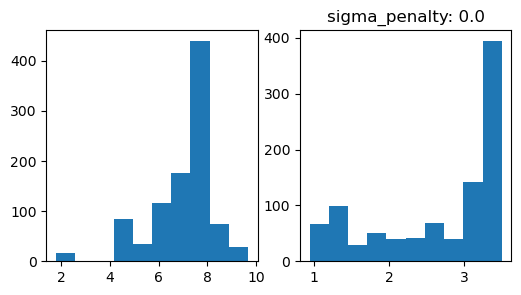

In [50]:
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(6,3))

ax.hist(y_pred_mean)
ax2.hist(y_pred_sigma)
ax2.set_title(f'sigma_penalty: {sigma_penalty}')

Text(0.5, 1.0, 'sigma_penalty: 0.1')

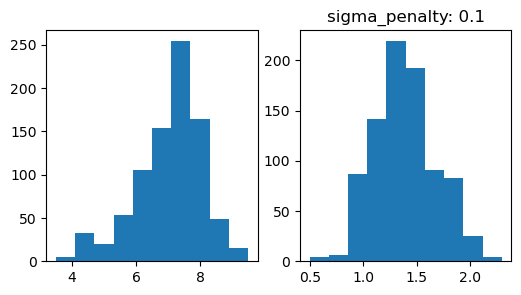

In [91]:
dist, y_pred_mean, y_pred_sigma = head_model(torch.Tensor(X_test))
y_pred_mean = y_pred_mean.detach().numpy()
y_pred_sigma = y_pred_sigma.detach().numpy()
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(6,3))

ax.hist(y_pred_mean)
ax2.hist(y_pred_sigma)
ax2.set_title(f'sigma_penalty: {sigma_penalty}')

In [114]:
dist, y_pred_mean, y_pred_sigma = head_model(torch.Tensor(X_test))
# get the predicted activity at each ph
y_ph, y_test_act = y_test[:,0], y_test[:,1]
y_pred_act = head_model.get_pred_act(dist, y_pred_mean, torch.Tensor(y_ph)).detach().numpy()
# now calculate the overall MAE
rho, _ = spearmanr(y_pred_act, y_test_act)  # spearman
mse = mean_squared_error(y_pred_act, y_test_act)  # Mean Squared Error
mae = np.mean(np.abs(y_pred_act - y_test_act))  # Mean Absolute Error
print(f"{sigma_penalty = }")
print(f"{mae = :0.2f}, {mse = :0.2f}, {rho = :0.2f}")

sigma_penalty = 0.1
mae = 0.27, mse = 0.12, rho = 0.40


In [46]:
dist, y_pred_mean, y_pred_sigma = head_model(torch.Tensor(X_test))
# get the predicted activity at each ph
y_ph, y_test_act = y_test[:,0], y_test[:,1]
y_pred_act = head_model.get_pred_act(dist, y_pred_mean, torch.Tensor(y_ph)).detach().numpy()
# now calculate the overall MAE
rho, _ = spearmanr(y_pred_act, y_test_act)  # spearman
mse = mean_squared_error(y_pred_act, y_test_act)  # Mean Squared Error
mae = np.mean(np.abs(y_pred_act - y_test_act))  # Mean Absolute Error
print(f"{sigma_penalty = }")
print(f"{mae = :0.2f}, {mse = :0.2f}, {rho = :0.2f}")

sigma_penalty = 0.1
mae = 0.30, mse = 0.15, rho = 0.32


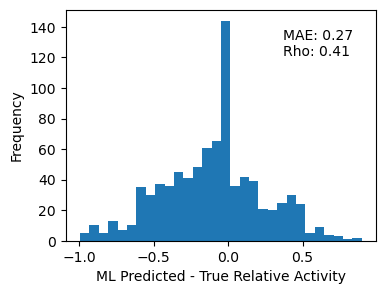

In [115]:
f, ax = plt.subplots(figsize=(4,3))
df = pd.DataFrame({'y_pred': y_pred_act, 'y_test': y_test_act})

df['y_err'] = (df['y_pred'] - df['y_test'])
df['y_err'].plot.hist(bins=30)

ax.set_xlabel("ML Predicted - True Relative Activity")

ax.text(0.7, 0.8, "MAE: 0.27 \nRho: 0.41",
        transform=ax.transAxes)

out_file = "results/20230914_ph_range/pred_err.pdf"
plt.savefig(out_file, bbox_inches='tight')

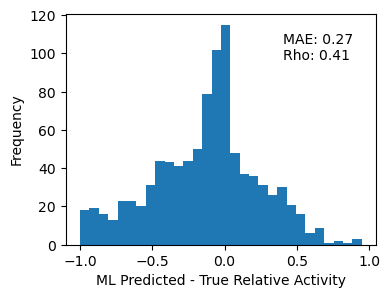

In [47]:
f, ax = plt.subplots(figsize=(4,3))
df = pd.DataFrame({'y_pred': y_pred_act, 'y_test': y_test_act})

df['y_err'] = (df['y_pred'] - df['y_test'])
df['y_err'].plot.hist(bins=30)

ax.set_xlabel("ML Predicted - True Relative Activity")

ax.text(0.7, 0.8, "MAE: 0.27 \nRho: 0.41",
        transform=ax.transAxes)

out_file = "results/20230914_ph_range/pred_err.pdf"
plt.savefig(out_file, bbox_inches='tight')

With additional "lt" and "gt" pH losses, MAE loss

Text(0.5, 1.0, 'sigma_penalty: 0.1')

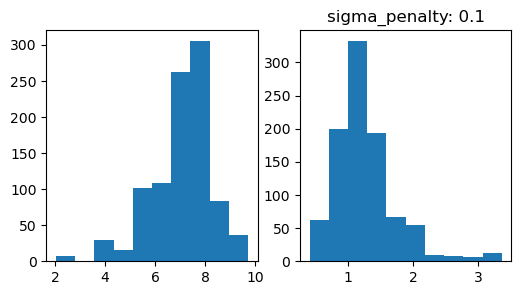

In [260]:
dist, y_pred_mean, y_pred_sigma = head_model(torch.Tensor(X_test))
y_pred_mean = y_pred_mean.detach().numpy()
y_pred_sigma = y_pred_sigma.detach().numpy()
y_pred_mean = y_pred_mean[y_test[:, 2] == 0]
y_pred_sigma = y_pred_sigma[y_test[:, 2] == 0]
f, (ax, ax2) = plt.subplots(ncols=2, figsize=(6,3))

ax.hist(y_pred_mean)
ax2.hist(y_pred_sigma)
ax2.set_title(f'sigma_penalty: {sigma_penalty}')

In [259]:
dist, y_pred_mean, y_pred_sigma = head_model(torch.Tensor(X_test))
# get the predicted activity at each ph
y_ph, y_test_act = y_test[:,0], y_test[:,1]
y_pred_act = head_model.get_pred_act(dist, y_pred_mean, torch.Tensor(y_ph)).detach().numpy()
y_pred_act = y_pred_act[y_test[:, 2] == 0]
y_test_act = y_test_act[y_test[:, 2] == 0]
# now calculate the overall MAE
rho, _ = spearmanr(y_pred_act, y_test_act)  # spearman
mse = mean_squared_error(y_pred_act, y_test_act)  # Mean Squared Error
mae = np.mean(np.abs(y_pred_act - y_test_act))  # Mean Absolute Error
print(f"{sigma_penalty = }")
print(f"{mae = :0.2f}, {mse = :0.2f}, {rho = :0.2f}")

sigma_penalty = 0.1
mae = 0.28, mse = 0.14, rho = 0.32


Text(0.7, 0.8, 'MAE: 0.27 \nRho: 0.41')

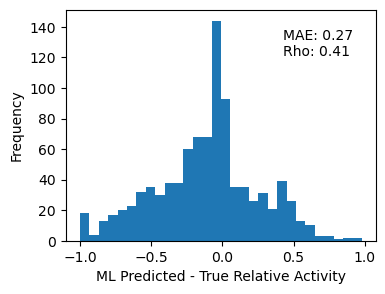

In [261]:
f, ax = plt.subplots(figsize=(4,3))
df = pd.DataFrame({'y_pred': y_pred_act, 'y_test': y_test_act})

df['y_err'] = (df['y_pred'] - df['y_test'])
df['y_err'].plot.hist(bins=30)

ax.set_xlabel("ML Predicted - True Relative Activity")

ax.text(0.7, 0.8, "MAE: 0.27 \nRho: 0.41",
        transform=ax.transAxes)

# out_file = "results/20230914_ph_range/pred_err.pdf"
# plt.savefig(out_file, bbox_inches='tight')

With l1 loss sum instead of mean

In [272]:
dist, y_pred_mean, y_pred_sigma = head_model(torch.Tensor(X_test))
# get the predicted activity at each ph
y_ph, y_test_act = y_test[:,0], y_test[:,1]
y_pred_act = head_model.get_pred_act(dist, y_pred_mean, torch.Tensor(y_ph)).detach().numpy()
y_pred_act = y_pred_act[y_test[:, 2] == 0]
y_test_act = y_test_act[y_test[:, 2] == 0]
# now calculate the overall MAE
rho, _ = spearmanr(y_pred_act, y_test_act)  # spearman
mse = mean_squared_error(y_pred_act, y_test_act)  # Mean Squared Error
mae = np.mean(np.abs(y_pred_act - y_test_act))  # Mean Absolute Error
print(f"{sigma_penalty = }")
print(f"{mae = :0.2f}, {mse = :0.2f}, {rho = :0.2f}")

sigma_penalty = 0.1
mae = 0.29, mse = 0.14, rho = 0.31


With leakyReLU

In [277]:
dist, y_pred_mean, y_pred_sigma = head_model(torch.Tensor(X_test))
# get the predicted activity at each ph
y_ph, y_test_act = y_test[:,0], y_test[:,1]
y_pred_act = head_model.get_pred_act(dist, y_pred_mean, torch.Tensor(y_ph)).detach().numpy()
y_pred_act = y_pred_act[y_test[:, 2] == 0]
y_test_act = y_test_act[y_test[:, 2] == 0]
# now calculate the overall MAE
rho, _ = spearmanr(y_pred_act, y_test_act)  # spearman
mse = mean_squared_error(y_pred_act, y_test_act)  # Mean Squared Error
mae = np.mean(np.abs(y_pred_act - y_test_act))  # Mean Absolute Error
print(f"{sigma_penalty = }")
print(f"{mae = :0.2f}, {mse = :0.2f}, {rho = :0.2f}")

sigma_penalty = 0.1
mae = 0.29, mse = 0.15, rho = 0.28


Text(0.7, 0.8, 'MAE: 0.27 \nRho: 0.41')

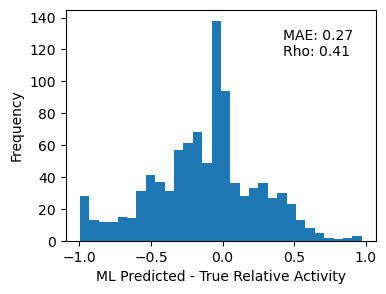

In [283]:
f, ax = plt.subplots(figsize=(4,3))
df = pd.DataFrame({'y_pred': y_pred_act, 'y_test': y_test_act})

df['y_err'] = (df['y_pred'] - df['y_test'])
df['y_err'].plot.hist(bins=30)

ax.set_xlabel("ML Predicted - True Relative Activity")

ax.text(0.7, 0.8, "MAE: 0.27 \nRho: 0.41",
        transform=ax.transAxes)

# out_file = "results/20230914_ph_range/pred_err.pdf"
# plt.savefig(out_file, bbox_inches='tight')

### Show plots for individual prots

In [53]:
df_test2 = df_test.reset_index(drop=True)
df_test_labels = df_test_labels.reset_index(drop=True)
df_train_labels = df_train_labels.reset_index(drop=True)

In [48]:
def get_ez_type(row):
    if row.oxidation == 1:
        return 'oxidation'
    elif row.reduction == 1:
        return 'reduction'

In [49]:
def plot_indv_prot_curves(df_test, y_pred_mean, y_pred_sigma, nrows=8, ncols=4):
    # get the predicted activity over all ph values
    all_ph_vals = np.arange(1, 13.5, 0.1)

    f, axes = plt.subplots(ncols=ncols, nrows=nrows, 
                           figsize=(8,4), 
                           sharey=True, sharex=False)
    axes_list = [ax for ax_row in axes for ax in ax_row]
    # cols = ["uniprot_id", "enzyme_type", "enzyme_type_sub", "acceptor"]
    i = -1
    df_redox = df_test[(df_test.oxidation == 1) |
                       (df_test.reduction == 1)]
    for (uniprot_id, df_u) in df_redox.groupby("uniprot_id"):
        df_u['enzyme_type'] = df_u.apply(get_ez_type, axis=1)
        df_u = df_u[df_u.enzyme_type.isin(["oxidation", "reduction"])]
        if len(df_u) <= 1:
            continue
        e_types = df_u.enzyme_type.unique()
        if 'oxidation' not in e_types or 'reduction' not in e_types:
            continue
        i += 1
        df_pred_act_u = []
        for (e_type, df_cat) in df_u.groupby('enzyme_type'):
            pred_mean_u = y_pred_mean[df_cat.index[0]].detach().numpy()
            pred_sigma_u = y_pred_sigma[df_cat.index[0]].detach().numpy()
            # print(uniprot_id, e_type, pred_mean_u, pred_sigma_u)
            pred_act = gaus(all_ph_vals, 1, pred_mean_u, pred_sigma_u)
            # limit the predicted activity to min_ph -1 and max_ph +1
            df_pred_act_u_cat = pd.DataFrame({'ph': all_ph_vals, 'activity': pred_act})
            df_pred_act_u_cat['enzyme_type'] = e_type
            ph_min = min(df_u.ph.min() - 1, 5.5)
            ph_max = max(df_u.ph.max() + 1, 8.5)
            df_pred_act_u_cat = df_pred_act_u_cat[(df_pred_act_u_cat.ph >= ph_min) & 
                                                  (df_pred_act_u_cat.ph <= ph_max)]
            df_pred_act_u += [df_pred_act_u_cat]
            # print(e_type, df_pred_act_u_cat[['ph', 'activity']].max())
        df_pred_act_u = pd.concat(df_pred_act_u)

        if i >= len(axes_list):
            break
        ax = axes_list[i]
        ax.set_title(uniprot_id, fontsize=6)
        sns.lineplot(x='ph', y='activity', data=df_pred_act_u, ax=ax,
                     # palette='deep', 
                     hue='enzyme_type', hue_order=['reduction', 'oxidation'],
                     size=1, 
                     legend=None)
        sns.scatterplot(x='ph', y='activity', data=df_u, ax=ax,
                        hue='enzyme_type', hue_order=['reduction', 'oxidation'],
                        palette='deep',
                        alpha=0.8,
                        legend=None
                       )
        ax.set_ylabel("")
        ax.set_xlabel("")
        # hide ax labels
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        # hide ax ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # add a vertical bar at ph=6--8
        ax.axvspan(6, 8, alpha=0.1, color='purple')
        # ax.set_xlabel
        # L = ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

    plt.show()
    plt.close()

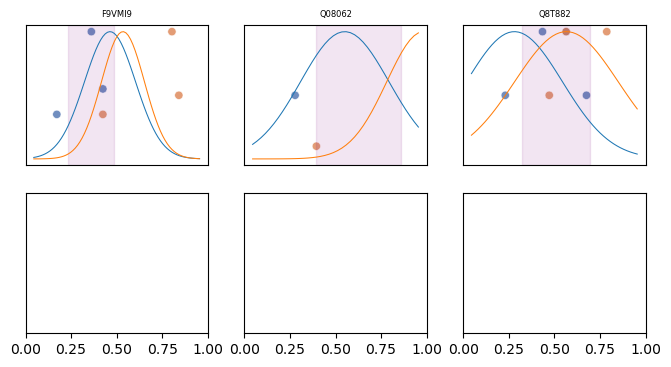

In [54]:
plot_indv_prot_curves(df_test_labels, y_pred_mean, y_pred_sigma,
                      nrows=2, ncols=3)

In [117]:
dist, y_train_mean, y_train_sigma = head_model(torch.Tensor(X_train))
# get the predicted activity at each ph
y_ph, y_act = y_train[:,0], y_train[:,1]
y_train_act = head_model.get_pred_act(dist, y_train_mean, torch.Tensor(y_ph)).detach().numpy()
# now calculate the overall MAE
rho, _ = spearmanr(y_train_act, y_act)  # spearman
mse = mean_squared_error(y_train_act, y_act)  # Mean Squared Error
mae = np.mean(np.abs(y_train_act - y_act))  # Mean Absolute Error
print(f"{mae = :0.2f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 0.12, mse = 0.0, rho = 0.80


In [51]:
dist, y_train_mean, y_train_sigma = head_model(torch.Tensor(X_train))
# get the predicted activity at each ph
y_ph, y_act = y_train[:,0], y_train[:,1]
y_train_act = head_model.get_pred_act(dist, y_train_mean, torch.Tensor(y_ph)).detach().numpy()
# now calculate the overall MAE
rho, _ = spearmanr(y_train_act, y_act)  # spearman
mse = mean_squared_error(y_train_act, y_act)  # Mean Squared Error
mae = np.mean(np.abs(y_train_act - y_act))  # Mean Absolute Error
print(f"{mae = :0.2f}, {mse = :0.2f}, {rho = :0.2f}")

mae = 0.11, mse = 0.04, rho = 0.80


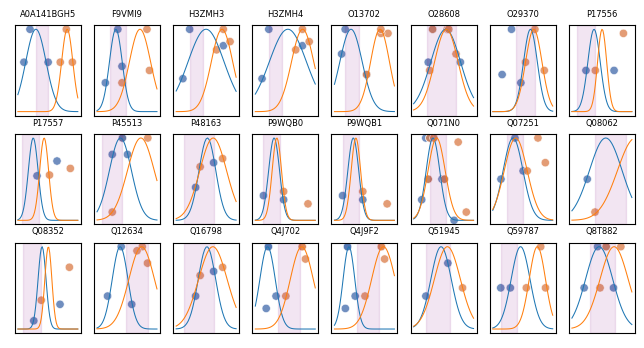

In [121]:
plot_indv_prot_curves(df_train_labels, y_train_mean, y_train_sigma, nrows=3, ncols=8)

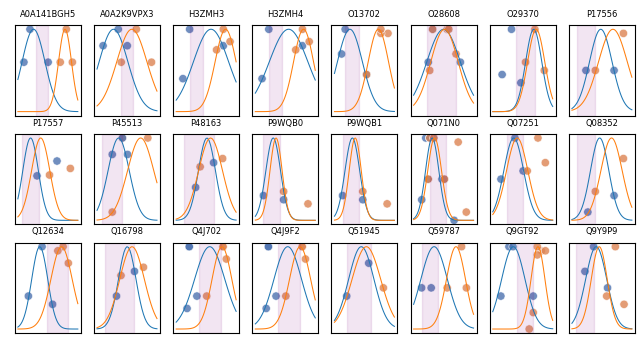

In [55]:
plot_indv_prot_curves(df_train_labels, y_train_mean, y_train_sigma, nrows=3, ncols=8)

In [122]:
df_train_labels[df_train_labels.uniprot_id == "Q08352"]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,oxidation,reduction
5319,4229,10.0,0.30,"maximum, maximum, reductive amination","pH 7.2: about 10% of activity maximum, pH 10.0...",Q08352,0,1
5320,4229,7.2,0.10,"maximum, maximum, reductive amination","pH 7.2: about 10% of activity maximum, pH 10.0...",Q08352,0,1
5325,4232,8.0,0.35,"maximum, maximum, oxidative deamination","pH 8: about 35% of activity maximum, pH 11: ab...",Q08352,1,0
5326,4232,11.0,0.75,"maximum, maximum, oxidative deamination","pH 8: about 35% of activity maximum, pH 11: ab...",Q08352,1,0


Also examine the curves for the train set

In [255]:
dist, y_train_mean, y_train_sigma = head_model(torch.Tensor(X_train))
# get the predicted activity at each ph
y_ph, y_act = y_train[:,0], y_train[:,1]
y_train_act = head_model.get_pred_act(dist, y_train_mean, torch.Tensor(y_ph)).detach().numpy()
y_train_act = y_train_act[y_train[:, 2] == 0]
y_act = y_act[y_train[:, 2] == 0]
# now calculate the overall MAE
rho, _ = spearmanr(y_train_act, y_act)  # spearman
mse = mean_squared_error(y_train_act, y_act)  # Mean Squared Error
mae = np.mean(np.abs(y_train_act - y_act))  # Mean Absolute Error
print(f"{mae = :0.2f}, {mse = :0.2f}, {rho = :0.2f}")

mae = 0.15, mse = 0.0, rho = 0.70


In [264]:
dist, y_train_mean, y_train_sigma = head_model(torch.Tensor(X_train))
# get the predicted activity at each ph
y_ph, y_act = y_train[:,0], y_train[:,1]
y_train_act = head_model.get_pred_act(dist, y_train_mean, torch.Tensor(y_ph)).detach().numpy()
y_train_act = y_train_act[y_train[:, 2] == 0]
y_act = y_act[y_train[:, 2] == 0]
# now calculate the overall MAE
rho, _ = spearmanr(y_train_act, y_act)  # spearman
mse = mean_squared_error(y_train_act, y_act)  # Mean Squared Error
mae = np.mean(np.abs(y_train_act - y_act))  # Mean Absolute Error
print(f"{mae = :0.2f}, {mse = :0.2f}, {rho = :0.2f}")

mae = 0.10, mse = 0.03, rho = 0.81


In [256]:
df_train.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,loss_type,exp_group,oxidation,reduction,sequence
2378,1598,5.0,0.5,within this range,over 50% of maximal activity within this range,A0A024CDT8,0,0,0,0,MTMLGMTKRLLLSAAVLAGLSGAVAAHAAPKQDLKGTNVVLVHGAF...
2379,1598,8.5,0.5,within this range,over 50% of maximal activity within this range,A0A024CDT8,0,0,0,0,MTMLGMTKRLLLSAAVLAGLSGAVAAHAAPKQDLKGTNVVLVHGAF...


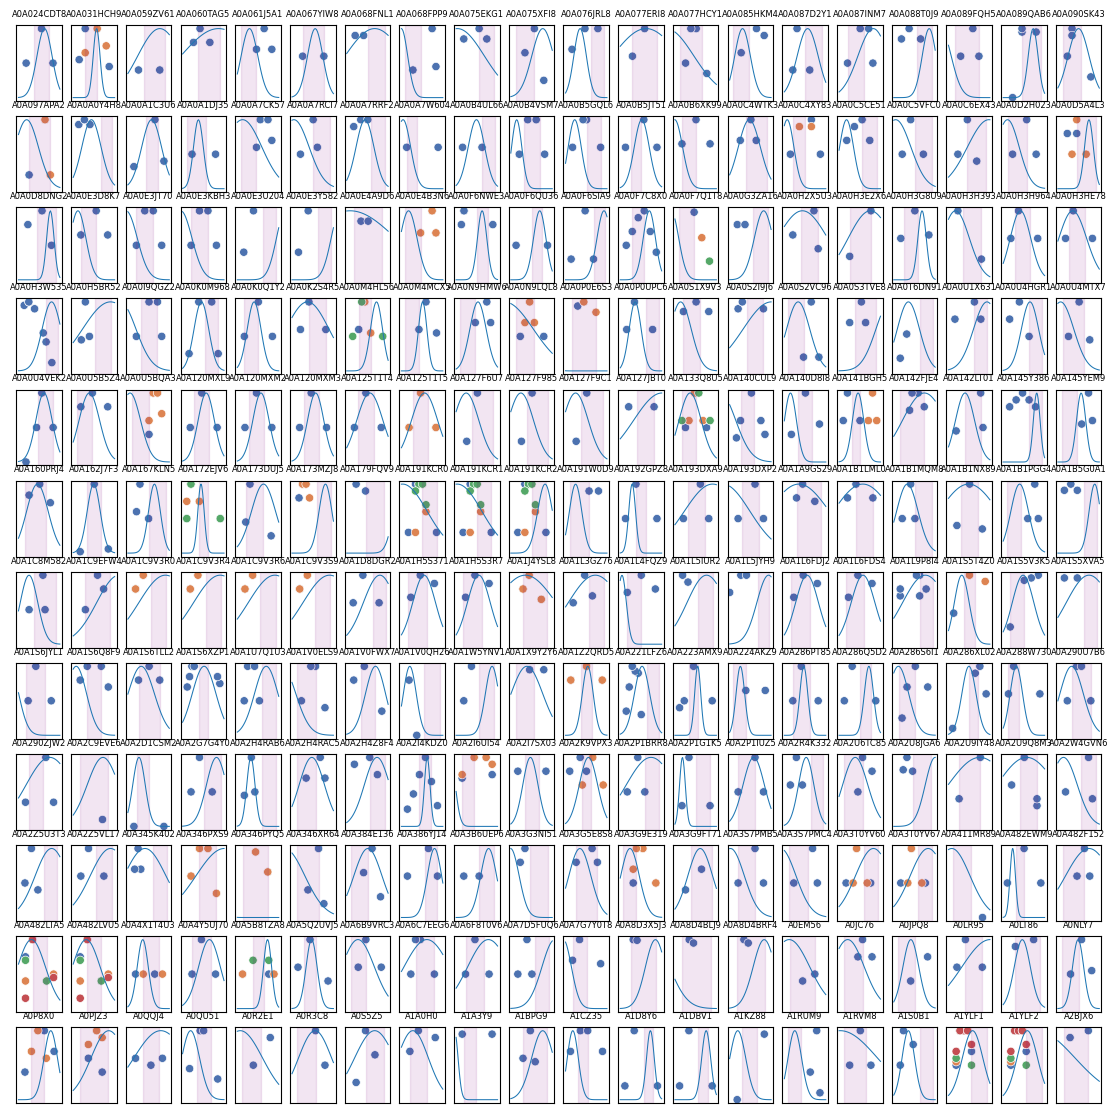

In [265]:
# get the predicted activity over all ph values
all_ph_vals = np.arange(1, 13.5, 0.1)

f, axes = plt.subplots(ncols=20, nrows=12, figsize=(14,14), sharey=True, sharex=False)
# f, axes = plt.subplots(ncols=20, nrows=2, figsize=(14,3), sharey=True, sharex=False)
axes_list = [ax for ax_row in axes for ax in ax_row]

for i, (uniprot_id, df_u) in enumerate(df_train.groupby("uniprot_id")):
    df_u = df_u[df_u.loss_type == 0]
    # get the predicted normal distribution and mean for this sequence
    # dist_u = dist[df_u.index[0]]  # can't subscript the normal object,
    # pred_act = head_model.get_pred_act(dist, y_pred_mean, torch.Tensor(all_ph_vals)).detach().numpy()
    # so instead just use the predicted mean and sigma
    pred_mean_u = y_train_mean[df_u.index[0]].detach().numpy()
    pred_sigma_u = y_train_sigma[df_u.index[0]].detach().numpy()
    pred_act = gaus(all_ph_vals, 1, pred_mean_u, pred_sigma_u)
    # limit the predicted activity to min_ph -1 and max_ph +1
    df_pred_act_u = pd.DataFrame({'ph': all_ph_vals, 'activity': pred_act})
    ph_min = min(df_u.ph.min() - 1, 5.5)
    ph_max = max(df_u.ph.max() + 1, 8.5)
    df_pred_act_u = df_pred_act_u[(df_pred_act_u.ph >= ph_min) & 
                                  (df_pred_act_u.ph <= ph_max)]
    
    # f, ax = plt.subplots(figsize=(3,3))
    ax = axes_list[i]
    ax.set_title(uniprot_id, fontsize=6)
    sns.lineplot(x='ph', y='activity', data=df_pred_act_u, ax=ax,
                 # palette='deep', 
                 size=1, 
                 legend=None)
    sns.scatterplot(x='ph', y='activity', data=df_u, ax=ax,
                    hue='exp_index', palette='deep',
                    legend=None
                   )
    ax.set_ylabel("")
    ax.set_xlabel("")
    # hide ax labels
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    # hide ax ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # add a vertical line at ph=7
    # ax.axvline(7, linestyle='dashed', linewidth=0.5)
    ax.axvspan(6, 8, alpha=0.1, color='purple')
    # L = ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
    # plt.show()
    # plt.close()
    if i >= len(axes_list) - 1:
        break
plt.show()
plt.close()

In [232]:
df_train[df_train.uniprot_id == "A0A089FQH5"]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,loss_type,exp_group,oxidation,reduction,sequence
4686,3085,7.5,1.0,-,NaN,A0A089FQH5,0,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
4687,3085,6.5,0.6,NaN,60% activity at pH 6.5 and 8.0,A0A089FQH5,0,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
4688,3085,8.0,0.6,NaN,60% activity at pH 6.5 and 8.0,A0A089FQH5,0,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
0,3085,1.0,0.6,NaN,NaN,A0A089FQH5,1,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
1,3085,1.5,0.6,NaN,NaN,A0A089FQH5,1,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
2,3085,2.0,0.6,NaN,NaN,A0A089FQH5,1,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
3,3085,2.5,0.6,NaN,NaN,A0A089FQH5,1,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
4,3085,3.0,0.6,NaN,NaN,A0A089FQH5,1,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
5,3085,3.5,0.6,NaN,NaN,A0A089FQH5,1,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...
6,3085,4.0,0.6,NaN,NaN,A0A089FQH5,1,18,0,0,MTTANIATNVSELARLKTLHNGAKEQLTFSDAEFERRLAGLRQIMA...


Examine some cases more closely

In [197]:
print(df_test[df_test.uniprot_id == "A0A223AMX9"][['exp_index', 'ph', 'activity']])
df_test[df_test.uniprot_id == "A0A223AMX9"].ph_range_comment.values

     exp_index   ph  activity
323       2433  5.0       0.5


array([' over 50% of maximal activity at pH 5.0-11.0, 40% at pH 4.0, profile overview '],
      dtype=object)

In [192]:
df_test[df_test.uniprot_id == "B3EWC6"]

,df_split_idx,exp_index,ph,activity,note,ph_range_comment,uniprot_id,sequence
207,1960,1457,4.6,0.5,NaN,"pH 4.6: about 50% of maximal activity, pH 5.6...",B3EWC6,NAPWAQIDEV
208,1961,1457,5.6,0.5,NaN,"pH 4.6: about 50% of maximal activity, pH 5.6...",B3EWC6,NAPWAQIDEV


In [187]:
print(df_test[df_test.uniprot_id == "A0A0T6DN91"][['exp_index', 'ph', 'activity']])
df_test[df_test.uniprot_id == "A0A0T6DN91"].ph_range_comment.values

    exp_index    ph  activity
46        299   4.0      0.04
47        299   5.0      1.00
48        299  10.0      1.00


array([' activity range, 53.4% of maximal activity at pH 4.0, 18.4% at pH 3.0  ',
       nan, nan], dtype=object)

In [201]:
print(df_test[df_test.uniprot_id == "I3ZTN9"][['exp_index', 'ph', 'activity']])
df_test[df_test.uniprot_id == "I3ZTN9"].ph_range_comment.values

     exp_index   ph  activity
243       1725  4.0      0.85
244       1725  5.0      1.00
245       1725  6.0      0.60


array([' pH 4.0: about 85% of maximal activity, pH 6.0: about 60% of maximal activity, alpha-1,4-glycosidic linkage hydrolysis of maltotriose ',
       nan,
       ' pH 4.0: about 85% of maximal activity, pH 6.0: about 60% of maximal activity, alpha-1,4-glycosidic linkage hydrolysis of maltotriose '],
      dtype=object)

In [200]:
[u for u in df_test.uniprot_id.unique() if "TN9" in u]

['I3ZTN9']

In [190]:
data_act_merged[data_act_merged.exp_index == 299]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id
438,299,4.0,0.040000,"activity range, 53.18.4% at pH 3.0","activity range, 53.4% of maximal activity at ...",A0A0T6DN91
439,299,5.0,1.000000,NaN,NaN,A0A0T6DN91
440,299,10.0,1.000000,NaN,NaN,A0A0T6DN91
8642,299,5.1,0.023810,ecoli_man,NaN,P07024
8643,299,6.0,0.206349,ecoli_man,NaN,P07024
8644,299,7.0,0.500000,ecoli_man,NaN,P07024
8645,299,8.0,0.793651,ecoli_man,NaN,P07024


In [125]:
head_model

neural_network_ph_act(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [ ]:
# TODO only count towards the loss function if the true activity != 1
# That way, only the mean will be affected, not the std dev

# I could also penalize the std dev for being too large by adding like std dev / 100 to the loss

# Even better would be to include features 

In [54]:
# y_pred = fit_predict(X_train, y_train, X_test).flatten()
# y_pred = model(torch.Tensor(X_test).to('cuda')[2].unsqueeze(1).detach().cpu()
y_pred = head_model(torch.Tensor(X_test)).detach().squeeze().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = (y_pred - y_test).abs().mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 0.8, mse = 1.2, rho = 0.62


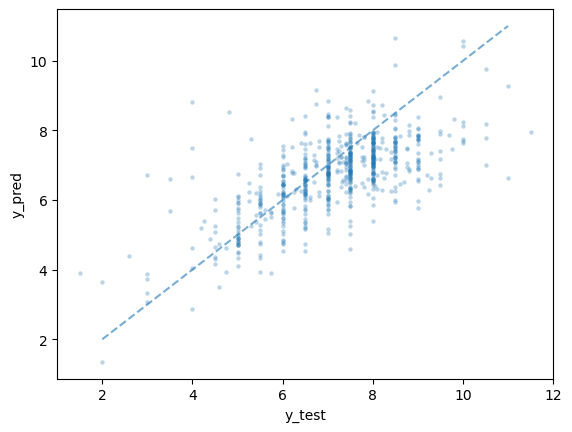

In [55]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
ax = df.plot.scatter(x='y_test', y='y_pred', alpha=0.3, lw=0, s=10)
# sns.scatter(data=df, x='y_test', y='y_pred', alpha=0.6)

ax.plot([2,11], [2,11], '--', alpha=0.6)
plt.show()

In [56]:
head_model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [174]:
# if __name__ == "__main__":
    out_file = Path(inputs_dir, f"meltome/embeddings/20230127_meltome_{model_name}.pt")
    print(out_file)
    torch.save(head_model, out_file)

/projects/robustmicrob/jlaw/inputs/meltome/embeddings/20230127_meltome_esm2_t33_650M_UR50D.pt


ReferenceError: weakly-referenced object no longer exists

### Also try predicting for specific sequences

In [25]:
model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [29]:
head_model = model

In [54]:
seqs_file = "/projects/bpms/jlaw/projects/pyruvate_decarboxylase_engineering/pdc_seqs.txt"
df_pdc = pd.read_csv(seqs_file, header=None, names=['seq_id', 'mutation', 'sequence'])
df_pdc['sequence'] = df_pdc.sequence.str.replace('HHHHHH-','')
df_pdc

,seq_id,mutation,sequence
0,WT,NaN,MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIY...
1,>pCB131,M296,MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIY...
2,>pCB139,M297,MYTVGMYLAERLAQIGLKHHFAVAGDYNLVLLDQLLLNKDMEQVYC...
3,>pCB140,M298,MTYTVGHYLAERLTQIGLKHHFAVAGDYNLVLLDQLIEQGGTKQIY...
4,>pCB141,M299,MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLVNKEMEQVY...


In [56]:
df_pdc.sequence.apply(len)

0    558
1    558
2    556
3    563
4    558
Name: sequence, dtype: int64

In [5]:
wt = df.sequence.values[0]
wt

'MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIYCCNELNCGFSAEGYARSNGAAAAVVTFSVGAISAMNAIGGAYAENLPVILISGSPNTNDYGTGHILHHTIGTTDYNYQLEMVKHVTCAAESIVSAEEAPAKIDHVIRTALRERKPAYLDIACNIASEPCVRPGPVSSLLSEPEIDHTSLKAAVDATVALLEKSASPVMLLGSKLRAANALAATETLADKLQCAVTIMAAAKGFFPEDHAGFRGLYWGEVSNPGVQELVETSDALLCIAPVFNDYSTVGWSAWPKGPNVILAEPDRVTVDGRAYDGFTLRAFLQALAEKAPARPASAQKSSVPTCSLTATSDEAGLTNDEIVRHINALLTSNTTLVAETGDSWFNAMRMTLPRGARVELEMQWGHIGWSVPSAFGNAMGSQDRQHVVMVGDGSFQVTAQEVAQMVRYELPVIIFLINNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAGEGHGLGLKATTPKELTEAIARAKANTRGPTLIECQIDRTDCTDMLVQWGRKVASTNARKTTLA'

In [55]:
df_pdc.sequence.values

array(['MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIYCCNELNCGFSAEGYARSNGAAAAVVTFSVGAISAMNAIGGAYAENLPVILISGSPNTNDYGTGHILHHTIGTTDYNYQLEMVKHVTCAAESIVSAEEAPAKIDHVIRTALRERKPAYLDIACNIASEPCVRPGPVSSLLSEPEIDHTSLKAAVDATVALLEKSASPVMLLGSKLRAANALAATETLADKLQCAVTIMAAAKGFFPEDHAGFRGLYWGEVSNPGVQELVETSDALLCIAPVFNDYSTVGWSAWPKGPNVILAEPDRVTVDGRAYDGFTLRAFLQALAEKAPARPASAQKSSVPTCSLTATSDEAGLTNDEIVRHINALLTSNTTLVAETGDSWFNAMRMTLPRGARVELEMQWGHIGWSVPSAFGNAMGSQDRQHVVMVGDGSFQVTAQEVAQMVRYELPVIIFLINNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAGEGHGLGLKATTPKELTEAIARAKANTRGPTLIECQIDRTDCTDMLVQWGRKVASTNARKTTLA',
       'MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIYCCNELNCGFSAEGYARSNGAAAAVVTFSVGAISAMNAIGGAYAENLPVILISGSPNTNDYGTGHILHHTIGTTDYNYQLEMVKHVTCAAESIVSAEEAPAKIDHVIRTALRERKPAYLDIACNIASEPCVRPGPVSSLLSEPEIDHTSLKAAVDATVALLEKSASPVMLLGSKLRAANALAATETLADKLQCAVTIMAAAKGFFPEDHAGFRGLYWGEVSNPGVQELVETSDALLCIAPVFNDYSTVGWSAWPKGPNVILAEPDRVTVDGRAYDGFTLRAFLQALAEKAPARPASAQKSSVPTCSLTATSDEAGLTNDEIVRHINALLTSNTTLVAETGDSWFNAMRMTLPRGARVELEMQWGHIGWSVPSAFGNAM

In [156]:
# model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.eval()  # disables dropout for deterministic results
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
# get the representations from the last layer
repr_layer = model.num_layers

In [57]:
print(f"building embeddings for {len(df_pdc)} embeddings using {repr_layer = }")
# print("current memory usage:")
# print_memory_usage()
# with autocast():
pdc_reps = get_seq_embeddings(model, df_pdc.sequence.values, repr_layer=repr_layer, batch_size=1)
print(f"{pdc_reps.shape = }")

building embeddings for 5 embeddings using repr_layer = 33


  0%|          | 0/5 [00:00<?, ?it/s]

pd_reps.shape = (5, 1280)


In [58]:
y_pred = head_model(torch.Tensor(pdc_reps)).detach().squeeze().numpy()
y_pred

array([48.356644, 48.356644, 47.259327, 48.632538, 47.968735],
      dtype=float32)

### Predict for pyuvate decarboxylase
- wt_tm = 62
- pdc_202 = ? - should be > wt_tm, but < pdc_203
- pdc_203 = 90

In [44]:
def apply_mutations(seq, muts):
    mut_seq = list(seq)
    for mut in muts:
        wt_aa, idx, mut_aa = mut[0], mut[1:-1], mut[-1]
        seq_idx = int(idx) - 1
        if wt_aa != seq[seq_idx]:
            print(f"WARNING: {wt_aa = } != {seq[seq_idx] = }")
        mut_seq[seq_idx] = mut_aa
    return ''.join(mut_seq)

apply_mutations("ABCDE", ["B2F"])

'AFCDE'

In [63]:
def get_mutations(wt_seq, mut_seq):
    mutations = []
    for i, aa in enumerate(wt_seq):
        if aa != mut_seq[i]:
            mut = f"{aa}{i + 1}{mut_seq[i]}"
            mutations.append(mut)
    return mutations

get_mutations("ABCDE", "AFCDE")

['B2F']

In [ ]:
A397P

In [70]:
test = [1,2,3].insert(0,5)
test

In [85]:
wt_seq = "MTYTVGMYLAERLVQIGLKHHFAVGGDYNLVLLDQLLLNKDMKQIYCCNELNCGFSAEGYARSNGAAAAVVTFSVGAISAMNALGGAYAENLPVILISGAPNSNDQGTGHILHHTIGKTDYSYQLEMARQVTCAAESITDAHSAPAKIDHVIRTALRERKPAYLDIACNIASEPCVRPGPVSSLLSEPEIDHTSLKAAVDATVALLKNRPAPVMLLGSKLRAANALAATETLADKLQCAVTIMAAAKGFFPEDHAGFRGLYWGEVSNPGVQELVETSDALLCIAPVFNDYSTVGWSGMPKGPNVILAEPDRVTVDGRAYDGFTLRAFLQALAEKAPARPASAQKSSVPTCSLTATSDEAGLTNDEIVRHINALLTSNTTLVAETGDSWFNAMRMTLAGARVELEMQWGHIGWSVPSAFGNAMGSQDRQHVVMVGDGSFQLTAQEVAQMVRYELPVIIFLINNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAGEGHGLGLKATTPKELTEAIARAKANTRGPTLIECQIDRTDCTDMLVQWGRKVASTNARKTTLA"
wt_seq = list(wt_seq)
wt_seq.insert(397, 'A')
wt_seq = ''.join(wt_seq)
# wt_seq
# wt_seq2 = "MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLANKEMEQVYCCNELNCGFSAEGYARAHGAAAAVVTFSVGAISAMNAIAGAYAENLPVILISGSPNSNDYGTGHILHHTLGTNDYTYQLEMMRHVTCAAESITDAASAPAKIDHVIRTALRERKPAYVEIACNISDAECVRPGPVSSLLAELRVDDVSLKAAVEASLALLEKSQRVTMIVGSKVRAAHAQTQTEHLADKLGCAVTIMAAAKSFFPEDHKGFRGLYWGDVSSPGAQELVEKSDALICVAPVFNDYSTVGWTAWPKGDNVLLAEPNRVTVGGKTYEGFTLREFLEELAKKAPSRPLTAQESKKHTPVIEAYKADARLTNDEMTRQINAMLTSDTTLVAETGDSWFNATRMDLPRGARVELEMQWGHIGWSVPSAFGNAMGSQERQHILMVGDGSFQLTAQEMAQMVRYKLPVIIFLVNNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAEDGHGLGLKATTAGELEEAIKKAKANREGPTIIECQIERSDCTKTLVEWGKKVAAANSRKPQVS"
pdc_var2 = "MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIYCCNELNCGFSAEGYARSNGAAAAVVTFSVGAISAMNAIGGAYAENLPVILISGSPNTNDYGTGHILHHTIGTTDYNYQLEMVKHVTCAAESIVSAEEAPAKIDHVIRTALRERKPAYLDIACNIASEPCVRPGPVSSLLSEPEIDHTSLKAAVDATVALLEKSASPVMLLGSKLRAANALAATETLADKLQCAVTIMAAAKGFFPEDHAGFRGLYWGEVSNPGVQELVETSDALLCIAPVFNDYSTVGWSAWPKGPNVILAEPDRVTVDGRAYDGFTLRAFLQALAEKAPARPASAQKSSVPTCSLTATSDEAGLTNDEIVRHINALLTSNTTLVAETGDSWFNAMRMTLPRGARVELEMQWGHIGWSVPSAFGNAMGSQDRQHVVMVGDGSFQVTAQEVAQMVRYELPVIIFLINNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAGEGHGLGLKATTPKELTEAIARAKANTRGPTLIECQIDRTDCTDMLVQWGRKVASTNARKTTLA"
print(len(wt_seq), len(wt_seq2), len(pdc_var2))
pdc_var2_muts = get_mutations(wt_seq, pdc_var2)

558 558 558


In [75]:
len(pdc_var2_muts)

24

In [91]:
# should have 13 mutations
corrected_wt_seq = list(wt_seq)
corrections = ['G25A','N208K','R209S','P210A', 'A211S', 'G297A', 'M298W', 'A397P', 'A398R']
apply_corrections = [f"{mut[-1]}{mut[1:-1]}{mut[0]}" for mut in corrections]
wt_seq = apply_mutations(wt_seq, corrections)
pdc_var2_muts = get_mutations(wt_seq, pdc_var2)
len(pdc_var2_muts)

15

In [90]:
print(', '.join(apply_mutations(wt_seq, pdc_var2_muts)))

L84I, A100S, S103T, Q106Y, K118T, S122N, A128V, R129K, Q130H, T139V, D140S, H142E, S143E, K207E, L441V


In [94]:
pdc_var1 = apply_mutations(wt_seq, pdc_var2_muts[:-1])

In [97]:
print(', '.join(get_mutations(wt_seq, pdc_var1)))

L84I, A100S, S103T, Q106Y, K118T, S122N, A128V, R129K, Q130H, T139V, D140S, H142E, S143E, K207E


In [88]:
wt_seq

'MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIYCCNELNCGFSAEGYARSNGAAAAVVTFSVGAISAMNALGGAYAENLPVILISGAPNSNDQGTGHILHHTIGKTDYSYQLEMARQVTCAAESITDAHSAPAKIDHVIRTALRERKPAYLDIACNIASEPCVRPGPVSSLLSEPEIDHTSLKAAVDATVALLKKSASPVMLLGSKLRAANALAATETLADKLQCAVTIMAAAKGFFPEDHAGFRGLYWGEVSNPGVQELVETSDALLCIAPVFNDYSTVGWSAWPKGPNVILAEPDRVTVDGRAYDGFTLRAFLQALAEKAPARPASAQKSSVPTCSLTATSDEAGLTNDEIVRHINALLTSNTTLVAETGDSWFNAMRMTLPRGARVELEMQWGHIGWSVPSAFGNAMGSQDRQHVVMVGDGSFQLTAQEVAQMVRYELPVIIFLINNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAGEGHGLGLKATTPKELTEAIARAKANTRGPTLIECQIDRTDCTDMLVQWGRKVASTNARKTTLA'

In [80]:
test_seqs = {'A0A368AB54': 'MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLANKEMEQVYCCNELNCGFSAEGYARAHGAAAAVVTFSVGAISAMNAIAGAYAENLPVILISGSPNSNDYGTGHILHHTLGTNDYTYQLEMMRHVTCAAESITDAASAPAKIDHVIRTALRERKPAYVEIACNVSDAECVRPGPVSSLLAELRVDDVSLKAAVEASLALLEKSQRVTVIVGSKVRAAHAQTQTEHLADKLGCAVTIMAAAKSFFPEDHKGFRGLYWGDVSSPGAQELVEKSDALICVAPVFNDYSTVGWTAWPKGDNVLLAEPNRVTVGGKTYEGFTLREFLEELAKKAPSRPLTAQESKKHTPVIEVSKADARLTNDEMTRQINAMLTSDTTLVAETGDSWFNATRMDLPRGARVELEMQWGHIGWSVPSAFGNAMGSQERQHILMVGDGSFQLTAQEMAQMVRYKLPVIIFLVNNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAEDGHGLGLKATTAGELEEAIKKAKANREGPTIIECQIERSDCTKTLVEWGKKVAAANSRKPQVS',
'A0A401WMT0': 'MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLANKEMEQVYCCNELNCGFSAEGYARAHGAAAAVVTFSVGAISAMNAIAGAYAENLPVILISGSPNSNDYGTGHILHHTLGTNDYTYQLEMMRHVTCAAESITDAASAPAKIDHVIRTALRERKPAYVEIACNVSDAECVRPGPVSSLLAELRVDDVSLKAAVEASLALLEKSQRVTVIVGSKVRAAHAQTQTEHLADKLGCAVTIMAAAKSFFPEDHKGFRGLYWGDVSSPGAQELVEKSDALICVAPVFNDYSTVGWTAWPKGDNVLLAEPNRVTVGGKTYEGFTLREFLEELAKKAPSRPLTAQESKKHTPVIEVSKADARLTNDEMTRQINAMLTSDTTLVAETGDSWFNATRMDLPRGARVELEMQWGHIGWSVPSAFGNAMGSQERQHILMVGDGSFQLTAQEMAQMVRYKLPVIIFLVNNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAEDGHGLGLKATTAGELEEAIKKAKANREGPTIIECQIERSDCTKTLVEWGKKVAAANSRKPQVS',
'A0A401WW73': 'MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLANKEMEQVYCCNELNCGFSAEGYARAHGAAAAVVTFSVGAISAMNAIAGAYAENLPVILISGSPNSNDYGTGHILHHTLGTNDYTYQLEMMRHVTCAAESITDAASAPAKIDHVIRTALRERKPAYVEIACNVSDAECVRPGPVSSLLAELRVDDVSLKAAVEASLALLEKSQRVTMIVGSKVRAAHAQTQTEHLADKLGCAVTIMAAAKSFFPEDHKGFRGLYWGDVSSPGAQELVEKSDALICVAPVFNDYSTVGWTAWPKGDNVLLAEPNRVTVGGKTYEGFTLREFLEELAKKAPSRPLTAQESKKHTPVIEASKADARLTNDEMTRQINAMLTSDTTLVAETGDSWFNATRMDLPRGARVELEMQWGHIGWSVPSAFGNAMGSQERQHILMVGDGSFQLTAQEMAQMVRYKLPVIIFLVNNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAEDGHGLGLKATTAGELEEAIKKAKANREGPTIIECQIERSDCTKTLVEWGKKVAAANSRKPQVS',
'A0A401XFT9': 'MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLANKEMEQVYCCNELNCGFSAEGYARAHGAAAAVVTFSVGAISAMNAIAGAYAENLPVILISGSPNSNDYGTGHILHHTLGTNDYTYQLEMMRHVTCAAESITDAASAPAKIDHVIRTALRERKPAYVEIACNISDAECVRPGPVSSLLAELRVDDVSLKAAVEASLALLEKSQRVTMIVGSKVRAAHAQTQTEHLADKLGCAVTIMAAAKSFFPEDHKGFRGLYWGDVSSPGAQELVEKSDALICVAPVFNDYSTVGWTAWPKGDNVLLAEPNRVTVGGKTYEGFTLREFLEELAKKAPSRPLTAQESKKHTPVIEASKADARLTNDEMTRQINAMLTSDTTLVAETGDSWFNATRMDLPRGARVELEMQWGHIGWSVPSAFGNAMGSQERQHILMVGDGSFQLTAQEMAQMVRYKLPVIIFLVNNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAEDGHGLGLKATTAGELEEAIKKAKANREGPTIIECQIERSDCTKTLVEWGKKVAAANSRKPQVS',
'A0A6P1QD67': 'MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLANKEMEQVYCCNELNCGFSAEGYARAHGAAAAVVTFSVGAISAMNAIAGAYAENLPVILISGSPNSNDYGTGHILHHTLGTNDYTYQLEMMRHVTCAAESITDAASAPAKIDHVIRTALRERKPAYVEIACNISDAECVRPGPVSSLLAELRVDDVSLKAAVEASLALLEKSQRVTMIVGSKVRAAHAQTQTEHLANKLGCAVTIMAAAKSFFPEDHKGFRGLYWGDVSSPGAQELVEKSDALICVAPVFNDYSTVGWTAWPKGDNVLLAEPNRVTVGGKTYEGFTLREFLEELAKKAPSRPLTAQESKKHTPVIEASKADARLTNDEMTRQINAMLTSDTTLVAETGDSWFNATRMDLPRGARVELEMQWGHIGWSVPSAFGNAMGSQERQHILMVGDGSFQLTAQEMAQMVRYKLPVIIFLVNNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAEDGHGLGLKATTAGELEEAIKKAKANREGPTIIECQIERSDCTKTLVEWGKKVAAANSRKPQVS',
'C7JF72': 'MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLVNKEMEQVYCCNELNCGFSAEGYARAHGAAAAVVTFSVGAISAMNAIAGAYAENLPVILISGSPNSNDYGTGHILHHTLGTNDYTYQLEMMRHVTCAAESITDAASAPAKIDHVIRTALRERKPAYVEIACNVSDAECVRPGPVSSLLAELRADDVSLKAAVEASLALLEKSQRVTMIVGSKVRAAHAQTQTEHLADKLGCAVTIMAAAKSFFPEDHKGFRGLYWGDVSSPGAQELVEKSDALICVAPVFNDYSTVGWTAWPKGDNVLLAEPNRVTVGGKTYEGFTLREFLEELAKKAPSRPLTAQESKKHTPVIEASKGDARLTNDEMTRQINAMLTSDTTLVAETGDSWFNATRMDLPRGARVELEMQWGHIGWSVPSAFGNAMGSQERQHILMVGDGSFQLTAQEMAQMVRYKLPVIIFLVNNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAEDGHGLGLKATTAGELEEAIKKAKTNREGPTIIECQIERSDCTKTLVEWGKKVAAANSRKPQVS',
'S6DAL0': 'MTYTVGMYLAERLSQIGLKHHFAVAGDFNLVLLDQLLANKEMEQVYCCNELNCGFSAEGYARAHGAAAAVVTFSVGAISAMNAIAGAYAENLPVILISGSPNSNDYGTGHILHHTLGTNDYTYQLEMMRHVTCAAESITDAASAPAKIDHVIRTALRERKPAYVEIACNISDAECVRPGPVSSLLAELRVDDVSLKAAVEASLALLEKSQRVTMIVGSKVRAAHAQTQTEHLADKLGCAVTIMAAAKSFFPEDHKGFRGLYWGDVSSPGAQELVEKSDALICVAPVFNDYSTVGWTAWPKGDNVLLAEPNRVTVGGKTYEGFTLREFLEELAKKAPSRPLTAQESKKHTPVIEAYKADARLTNDEMTRQINAMLTSDTTLVAETGDSWFNATRMDLPRGARVELEMQWGHIGWSVPSAFGNAMGSQERQHILMVGDGSFQLTAQEMAQMVRYKLPVIIFLVNNRGYVIEIAIHDGPYNYIKNWDYAGLMEVFNAEDGHGLGLKATTAGELEEAIKKAKANREGPTIIECQIERSDCTKTLVEWGKKVAAANSRKPQVS',
}
for u_id, test_seq in test_seqs.items():
    # test_seq = list(test_seq)
    # test_seq.insert(397, 'A')
    # test_seq = ''.join(test_seq)
    print(len(test_seq), len(get_mutations(test_seq, pdc_var2)))

558 123
558 123
558 121
558 120
558 121
558 122
558 120


In [45]:
wt_seq = "MSYTVGTYLAERLVQIGLKHHFAVAGDYNLVLLDNLLLNKNMEQVYCCNELNCGFSAEGYARAKGAAAAVVTYSVGALSAFDAIGGAYAENLPVILISGAPNNNDHAAGHVLHHALGKTDYHYQLEMAKNITAAAEAIYTPEEAPAKIDHVIKTALREKKPVYLEIACNIASMPCAAPGPASALFNDEASDEASLNAAVEETLKFIANRDKVAVLVGSKLRAAGAEEAAVKFADALGGAVATMAAAKSFFPEENPHYIGTSWGEVSYPGVEKTMKEADAVIALAPVFNDYSTTGWTDIPDPKKLVLAEPRSVVVNGIRFPSVHLKDYLTRLAQKVSKKTGALDFFKSLNAGELKKAAPADPSAPLVNAEIARQVEALLTPNTTVIAETGDSWFNAQRMKLPNGARVEYEMQWGHIGWSVPAAFGYAVGAPERRNILMVGDGSFQLTAQEVAQMVRLKLPVIIFLINNYGYTIEVMIHDGPYNNIKNWDYAGLMEVFNGNGGYDSGAGKGLKAKTGGELAEAIKVALANTDGPTLIECFIGREDCTEELVKWGKRVAAANSRKPVNKLL"
pdc_202_muts = ["S2D", "L38D", "A207E", "G224A", "Q333E", "A357D", "V374I", "A376D", "A519E", "A527D", "G540A", "K553E"]
pdc_203_muts = ["S2D", "L38D", "G109A", "A207E", "G224A", "Q333E", "A357D", "V374I", "A376D", "G491A", "G515A", "G516A", "A519E", "A527D", "K553E", "G540A"]
pdc_202 = apply_mutations(wt_seq, pdc_202_muts)
pdc_203 = apply_mutations(wt_seq, pdc_203_muts)

In [59]:
pdc_203

'MDYTVGTYLAERLVQIGLKHHFAVAGDYNLVLLDNLLDNKNMEQVYCCNELNCGFSAEGYARAKGAAAAVVTYSVGALSAFDAIGGAYAENLPVILISGAPNNNDHAAAHVLHHALGKTDYHYQLEMAKNITAAAEAIYTPEEAPAKIDHVIKTALREKKPVYLEIACNIASMPCAAPGPASALFNDEASDEASLNAAVEETLKFIENRDKVAVLVGSKLRAAAAEEAAVKFADALGGAVATMAAAKSFFPEENPHYIGTSWGEVSYPGVEKTMKEADAVIALAPVFNDYSTTGWTDIPDPKKLVLAEPRSVVVNGIRFPSVHLKDYLTRLAEKVSKKTGALDFFKSLNAGELKKADPADPSAPLVNAEIARQIEDLLTPNTTVIAETGDSWFNAQRMKLPNGARVEYEMQWGHIGWSVPAAFGYAVGAPERRNILMVGDGSFQLTAQEVAQMVRLKLPVIIFLINNYGYTIEVMIHDGPYNNIKNWDYAALMEVFNGNGGYDSGAGKGLKAKTAAELEEAIKVALDNTDGPTLIECFIAREDCTEELVKWGERVAAANSRKPVNKLL'

In [46]:
seqs = [wt_seq, pdc_202, pdc_203]
print(f"building embeddings for {len(seqs)} sequences using {repr_layer = }")
pdc_reps = get_seq_embeddings(model, seqs, repr_layer=repr_layer, batch_size=1)
print(f"{pdc_reps.shape = }")

building embeddings for 3 embeddings using repr_layer = 33


  0%|          | 0/3 [00:00<?, ?it/s]

pdc_reps.shape = (3, 1280)


In [47]:
y_pred = head_model(torch.Tensor(pdc_reps)).detach().squeeze().numpy()
y_pred

array([50.107574, 49.430996, 49.747066], dtype=float32)

### Sutiono etal Table 1

In [99]:
df_pdc_sutiono = pd.read_csv("/projects/robustmicrob/jlaw/projects/prot_stability_engineering/inputs/lit/pyruvate_decarboxylase_examples.csv")
df_pdc_sutiono.head(2)

,enzyme,Tm,uniprot_id,mutations,sequence
0,CgPDC,55.5,Q6FJA3,-,MSEITLGRYLFERLNQVDVKTIFGLPGDFNLSLLDKIYEVEGMRWA...
1,ZrPDC,50.5,A0A1Q2ZTD3(?),-,MYVDTTSMGPTITIADYFFHRLKQLEVLTIFGLPGEFNAPLIDKLY...


In [148]:
# generate the embeddings for these sequences
def get_seq_embeddings(model, seqs, repr_layer=33, batch_size=16):
    """
    Generate an embedding for every sequence using the specified model
    """
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(np.arange(len(seqs)), seqs)))

    batch_dataloader = torch.utils.data.DataLoader(batch_tokens,
                                                   batch_size=batch_size,
                                                   pin_memory=True,
                                                   num_workers=8
                                                  )

    representations = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(batch_dataloader), total=len(batch_dataloader)):
            out = model(batch.to(device), repr_layers=[repr_layer])  # because this is the 33-layer transformer
            out = out['representations'][repr_layer].detach().to('cpu').numpy()

            for i in range(len(batch)):
                seq_idx = (batch_idx * batch_size) + i
                representations += [out[i, 1:len(seqs[seq_idx]) + 1].mean(0).astype(np.float16)]

            # if batch_idx == 0 or batch_idx % int(len(batch_dataloader) / 20.0) == 0:
            #     # keep track of how much memory this script is using
            #     print_memory_usage()
    representations = np.vstack(representations)
    return representations

In [157]:
print(f"building embeddings for {len(df_pdc_sutiono)} sequences using {repr_layer = }")
pdc_reps = get_seq_embeddings(model, df_pdc_sutiono.sequence.values, repr_layer=repr_layer, batch_size=8)
print(f"{pdc_reps.shape = }")

building embeddings for 10 sequences using repr_layer = 33


  0%|          | 0/2 [00:00<?, ?it/s]

pdc_reps.shape = (10, 1280)


In [158]:
y_pred = head_model(torch.Tensor(pdc_reps)).detach().squeeze().numpy()
df_pdc_sutiono['Tm_pred'] = y_pred
df_pdc_sutiono

,enzyme,Tm,uniprot_id,mutations,sequence,Tm_pred
0,CgPDC,55.5,Q6FJA3,-,MSEITLGRYLFERLNQVDVKTIFGLPGDFNLSLLDKIYEVEGMRWA...,46.859035
1,ZrPDC,50.5,A0A1Q2ZTD3(?),-,MYVDTTSMGPTITIADYFFHRLKQLEVLTIFGLPGEFNAPLIDKLY...,46.277348
2,ApPDC,-,Q8L388,-,MTYTVGMYLAERLVQIGLKHHFAVGGDYNLVLLDQLLLNKDMKQIY...,46.973988
3,ZmPDC,66.5,P06672,-,MSYTVGTYLAERLVQIGLKHHFAVAGDYNLVLLDNLLLNKNMEQVY...,46.564384
4,ZpPDC,65,Q8KTX6,-,MYTVGMYLAERLAQIGLKHHFAVAGDYNLVLLDQLLLNKDMEQVYC...,46.444767
5,5NPU7,55.5,-,-,-,51.594395
6,5TMA8,59.5,P06672,"S2D, L38D, G109A, A207E, G224A, Q333E, A357D, ...",MDYTVGTYLAERLVQIGLKHHFAVAGDYNLVLLDNLLDNKNMEQVY...,46.487659
7,ApPDC,70,wt_seq,-,MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIY...,47.094990
8,PDC-Var. 1,77,wt_seq,"L84I, A100S, S103T, Q106Y, K118T, S122N, A128V...",MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIY...,46.744820
9,PDC-Var. 2,82,wt_seq,"L84I, A100S, S103T, Q106Y, K118T, S122N, A128V...",MTYTVGMYLAERLVQIGLKHHFAVAGDYNLVLLDQLLLNKDMKQIY...,46.855122


In [166]:
df_pdc_sutiono[df_pdc_sutiono.Tm != '-'].set_index('enzyme')[['Tm', 'Tm_pred']].astype(float).round(1)

,Tm,Tm_pred
enzyme,,
CgPDC,55.5,46.9
ZrPDC,50.5,46.3
ZmPDC,66.5,46.6
ZpPDC,65.0,46.4
5NPU7,55.5,51.6
5TMA8,59.5,46.5
ApPDC,70.0,47.1
PDC-Var. 1,77.0,46.7
PDC-Var. 2,82.0,46.9


<AxesSubplot: xlabel='Tm', ylabel='Tm_pred'>

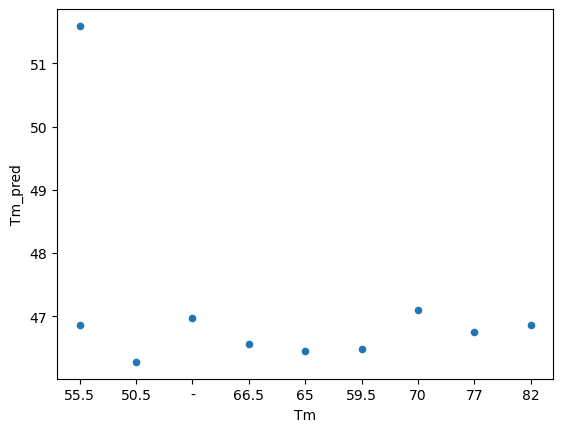

In [160]:
df_pdc_sutiono[['Tm', 'Tm_pred']].plot.scatter(x='Tm', y='Tm_pred')